In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping

from wordcloud import WordCloud
%matplotlib inline

In [2]:
import os

In [3]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [4]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv" , low_memory=True,usecols=["user_id","anime_id","rating"])

In [5]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [6]:
len(rating_df)

5000000

In [7]:
n_ratings = rating_df["user_id"].value_counts()

In [8]:
type(n_ratings)

pandas.core.series.Series

In [10]:
rating_df['user_id'].index

RangeIndex(start=0, stop=5000000, step=1)

In [11]:
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings>=400].index)].copy()

In [12]:
len(rating_df)

3246641

In [15]:
type(rating_df["rating"])

pandas.core.series.Series

In [16]:
min_rating =min(rating_df["rating"])

In [17]:
max_rating =max(rating_df["rating"])

In [18]:
max_rating

10

In [19]:
avg_rating =np.mean(rating_df["rating"])

In [20]:
avg_rating

np.float64(4.122732695114736)

In [150]:
rating_df["rating"] = rating_df["rating"].apply(
    lambda x: (x - min_rating) / (max_rating - min_rating)
).values.astype(np.float32)


In [151]:
rating_df['rating'].value_counts()

rating
0.0    1406616
0.8     449664
0.7     441361
0.9     271936
0.6     242175
1.0     173100
0.5     134026
0.4      62292
0.3      31579
0.2      18793
0.1      15099
Name: count, dtype: int64

In [152]:
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x : i for i , x in enumerate(user_ids)}
user2user_decoded = {i : x for i , x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)


In [153]:
n_users = len(user2user_encoded)

In [154]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x : i for i , x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i , x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [155]:
n_anime = len(anime2anime_encoded)

In [156]:
X = rating_df[["user","anime"]].values
y = rating_df["rating"]

In [157]:
X

array([[   0,    0],
       [   0,    1],
       [   0,    2],
       ...,
       [4202, 2455],
       [4202, 2154],
       [4202, 6584]])

In [158]:
y

213        0.0
214        1.0
215        0.0
216        0.0
217        0.0
          ... 
4999916    0.0
4999917    0.0
4999918    0.0
4999919    0.0
4999920    0.0
Name: rating, Length: 3246641, dtype: float32

In [159]:
rating_df.head().user_id.values[0]

np.int64(2)

In [160]:
rating_df.index

Index([    213,     214,     215,     216,     217,     218,     219,     220,
           221,     222,
       ...
       4999911, 4999912, 4999913, 4999914, 4999915, 4999916, 4999917, 4999918,
       4999919, 4999920],
      dtype='int64', length=3246641)

In [161]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [162]:
X_train , X_test , y_train , y_test = (
    X[:train_indices],
    X[train_indices :],
    y[:train_indices],
    y[train_indices:],
)

In [163]:
len(X_train)

3245641

In [164]:
y_train.value_counts()

rating
0.0    1406265
0.8     449605
0.7     441232
0.9     271893
0.6     242053
1.0     173083
0.5     133898
0.4      62202
0.3      31540
0.2      18778
0.1      15092
Name: count, dtype: int64

In [165]:
len(X_test)

1000

In [166]:
X_train_array = [X_train[: , 0] , X_train[: ,1]]
X_test_array = [X_test[: , 0] , X_test[: ,1]]

Model Architecture

In [167]:
def RecommenderNet():
    embedding_size =128

    user = Input(name="user",shape=[1])
 
    user_embedding = Embedding(name="user_embedding",input_dim=n_users,output_dim=embedding_size)(user)

    anime = Input(name="anime",shape=[1])

    anime_embedding = Embedding(name="anime_embedding",input_dim=n_anime,output_dim=embedding_size)(anime)

    x = Dot(name="dot_product" , normalize=True , axes=2)([user_embedding,anime_embedding])

    x = Flatten()(x)

    x = Dense(1,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user,anime], outputs=x)
    model.compile(loss="binary_crossentropy",metrics=["mae","mse"] ,optimizer='Adam')
    return model

In [168]:
model = RecommenderNet()

In [169]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          2 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [170]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_lr

In [171]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch) , verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor="val_loss",mode="min",save_best_only=True)

early_stopping = EarlyStopping(patience=3,monitor="val_loss",mode="min",restore_best_weights=True)

In [172]:
my_callbacks = [model_checkpoint,lr_callback,early_stopping]

In [173]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data = (X_test_array,y_test),
    callbacks=my_callbacks
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - loss: 0.6938 - mae: 0.3612 - mse: 0.1559 - val_loss: 0.6929 - val_mae: 0.2813 - val_mse: 0.1154 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - loss: 0.6931 - mae: 0.3609 - mse: 0.1555 - val_loss: 0.6924 - val_mae: 0.2819 - val_mse: 0.1151 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - loss: 0.6922 - mae: 0.3606 - mse: 0.1550 - val_loss: 0.6922 - val_mae: 0.2821 - val_mse: 0.1150 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - loss: 0.6912 - mae: 0.3605 - mse: 0.1545 - val_loss: 0.6909 - val_mae: 0.2818 - val_mse: 0.1144 - learning_rate: 3.4000e-05
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - loss: 0.6900 - mae: 0.3605 - mse: 0.1539 - val_loss: 0.6897 - val_mae: 0.2819 - val_mse: 0.1138 - learning_rate: 4.2000e-05
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - loss: 0.6880 - mae: 0.3600 - mse: 0.1530 - v

In [174]:
model.load_weights(checkpoint_filepath)

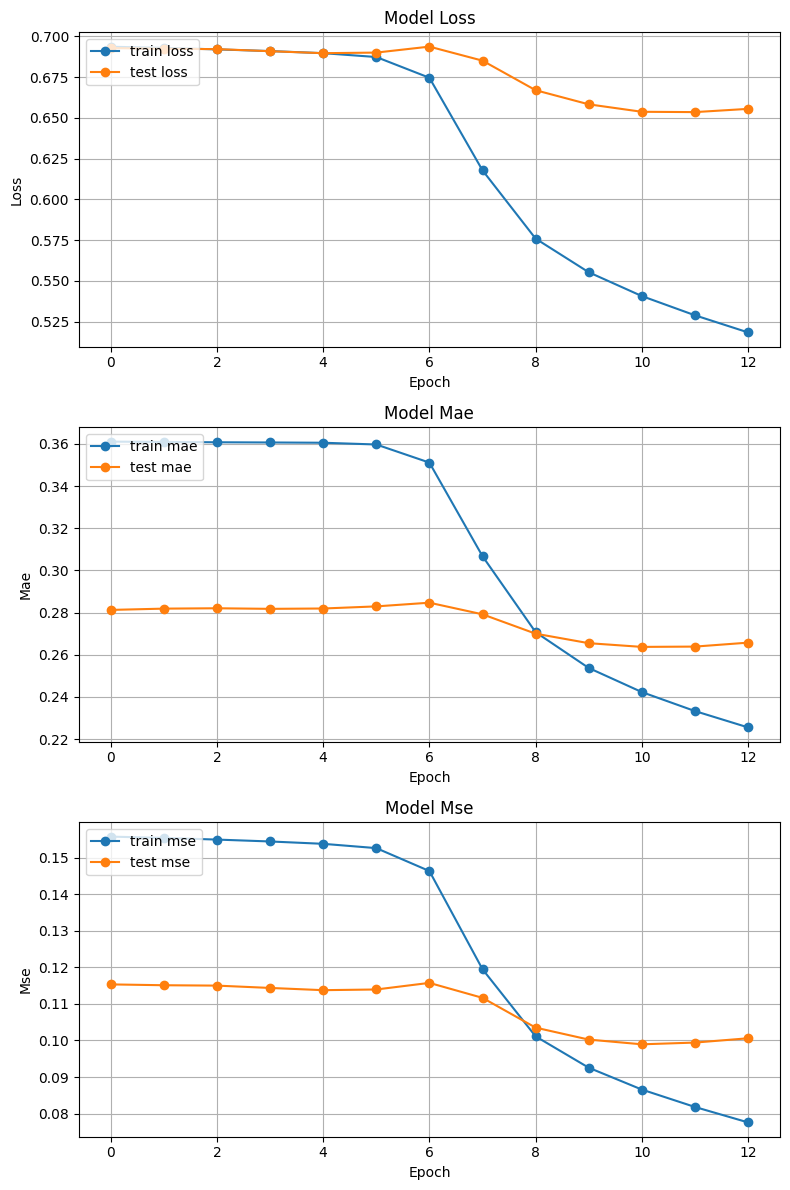

In [175]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [176]:
def extract_weights(name,model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

In [177]:
anime_weights = extract_weights("anime_embedding",model)

In [178]:
user_weights = extract_weights("user_embedding",model)

#### READING ANIME.CSV

In [179]:
df = pd.read_csv(INPUT_DIR+"/anime.csv",low_memory=True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [180]:
df = df.replace("Unknown",np.nan)

In [181]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")
    return name

In [182]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x:getAnimeName(x))

In [183]:
getAnimeName(6702)

'Fairy Tail'

In [184]:
df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last")

In [185]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [186]:
df = df[["anime_id" , "eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]

In [187]:
df.head(2)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260


In [188]:
def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df.anime_id == anime]
    if isinstance(anime,str):
        return df[df.eng_version == anime]
    

In [189]:
getAnimeFrame(40028 , df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260


In [190]:
getAnimeFrame("Steins;Gate",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


#### ANIME_WITH_SYNOPSIS.CSV 

In [191]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]

In [192]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv",usecols=cols)

In [193]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."


In [194]:
synopsis_df.columns

Index(['MAL_ID', 'Name', 'Genres', 'sypnopsis'], dtype='object')

In [195]:
def getSynopsis(anime,synopsis_df):
    if isinstance(anime,int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]
    

In [196]:
getSynopsis(40028 , synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [197]:
getSynopsis("Steins;Gate",synopsis_df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

### CONTENT/ITEM BASED RECOMMENDATION

In [198]:
pd.set_option("display.max_colwidth", None)

In [220]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    # Get the anime_id for the given name
    index = getAnimeFrame(name, df).anime_id.values[0]
    encoded_index = anime2anime_encoded.get(index)

    if encoded_index is None:
        raise ValueError(f"Encoded index not found for anime ID: {index}")

    weights = anime_weights

    # Compute the similarity distances
    dists = np.dot(weights, weights[encoded_index])  # Ensure weights[encoded_index] is a 1D array
    sorted_dists = np.argsort(dists)

    n = n + 1

    # Select closest or farthest based on 'neg' flag
    if neg:
        closest = sorted_dists[:n]
    else:
        closest = sorted_dists[-n:]

    # Return distances and closest indices if requested
    if return_dist:
        return dists, closest

    # Build the similarity array
    SimilarityArr = []
    for close in closest:
        decoded_id = anime2anime_decoded.get(close)
       

       
        anime_frame = getAnimeFrame(decoded_id, df)

        anime_name = anime_frame.eng_version.values[0]
        genre = anime_frame.Genres.values[0]
        similarity = dists[close]
   

        SimilarityArr.append({
            "anime_id": decoded_id,
            "name": anime_name,
            "similarity": similarity,
            "genre": genre,
        })
       

    # Create a DataFrame with results and sort by similarity
    Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
    return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)


In [221]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
)

,name,similarity,genre
9,Fullmetal Alchemist:Brotherhood,0.851654,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
8,Code Geass:Lelouch of the Rebellion R2,0.849117,"Action, Military, Sci-Fi, Super Power, Drama, Mecha"
7,Code Geass:Lelouch of the Rebellion,0.844448,"Action, Military, Sci-Fi, Super Power, Drama, Mecha, School"
6,Fate/Zero Season 2,0.842341,"Action, Supernatural, Magic, Fantasy"
5,Attack on Titan,0.834632,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen"
4,One Punch Man,0.831367,"Action, Sci-Fi, Comedy, Parody, Super Power, Supernatural"
3,Death Note,0.812419,"Mystery, Police, Psychological, Supernatural, Thriller, Shounen"
2,"No Game, No Life",0.806193,"Game, Adventure, Comedy, Supernatural, Ecchi, Fantasy"
1,Your Name.,0.800292,"Romance, Supernatural, School, Drama"
0,Angel Beats!,0.794264,"Action, Comedy, Drama, School, Supernatural"


### USER BASED RECOMMENDATION

In [222]:
def find_similar_users(item_input , user_weights , user2user_encoded , user2user_decoded, n=10 , return_dist=False,neg=False):
    try:
        index=item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            

        if return_dist:
            return dists,closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input,int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                })
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users
    except Exception as e:
        print("Error Occured",e)

        
        

In [223]:
find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

,similar_users,similarity
9,2641,0.499984
8,7135,0.498713
7,2236,0.498197
6,12699,0.491388
5,9214,0.485868
4,16046,0.481149
3,3651,0.480308
2,14043,0.477933
1,5581,0.477866
0,13116,0.476395


In [229]:
rating_df.tail()

,user_id,anime_id,rating,user,anime
4999916,16507,8985,0.0,4202,2533
4999917,16507,5454,0.0,4202,817
4999918,16507,15911,0.0,4202,2455
4999919,16507,878,0.0,4202,2154
4999920,16507,308,0.0,4202,6584


In [243]:
animie_watched_by_user = rating_df[rating_df.user_id==2]

In [244]:
animie_watched_by_user

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4
...,...,...,...,...,...
702,2,36720,0.0,0,489
703,2,40519,0.0,0,490
704,2,38831,0.0,0,491
705,2,1195,0.0,0,492


In [245]:
percentile = np.percentile(animie_watched_by_user.rating, 90)

In [246]:
percentile

np.float32(0.7)

In [247]:
animes_watched_by_user = animie_watched_by_user[animie_watched_by_user.rating >= percentile]

In [251]:
animes_watched_by_user.shape

(55, 5)

In [252]:
top_animes_user = (
        animes_watched_by_user.sort_values(by="rating" , ascending=False).anime_id.values
    )

In [253]:
top_animes_user

array([  235,  1535,  2904,   263, 11061,    22, 33486,    15,  1575,
          20,  1735, 30276,  5040, 16498, 34134,  9253,  1604, 26055,
       14719, 20899, 15451,   270,    21, 28171, 32182, 23755, 24703,
         226, 28223, 35581, 29575,   368, 31964, 35028,    71,  7593,
        5042, 38671,  7661,  3455, 29786, 22319, 10620, 37086, 34933,
         189, 22535, 32872, 31740,  5762, 31580, 34599, 28961, 34542,
       11499])

In [254]:
df[df["anime_id"].isin(top_animes_user)]

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
6474,11061,Hunter x Hunter,9.1,"Action, Adventure, Fantasy, Shounen, Super Power",148,TV,Fall 2011,1673924
2656,2904,Code Geass:Lelouch of the Rebellion R2,8.91,"Action, Military, Sci-Fi, Super Power, Drama, Mecha",25,TV,Spring 2008,1268320
239,263,Fighting Spirit,8.75,"Comedy, Sports, Drama, Shounen",75,TV,Fall 2000,383603
12500,34599,Made in Abyss,8.74,"Sci-Fi, Adventure, Mystery, Drama, Fantasy",13,TV,Summer 2017,862410
1431,1575,Code Geass:Lelouch of the Rebellion,8.72,"Action, Military, Sci-Fi, Super Power, Drama, Mecha, School",25,TV,Fall 2006,1583882
1393,1535,Death Note,8.63,"Mystery, Police, Psychological, Supernatural, Thriller, Shounen",37,TV,Fall 2006,2589552
10451,30276,One Punch Man,8.57,"Action, Sci-Fi, Comedy, Parody, Super Power, Supernatural",12,TV,Fall 2015,2123866
11,21,One Piece,8.52,"Action, Adventure, Comedy, Super Power, Drama, Fantasy, Shounen",NaN,TV,Fall 1999,1352724
11260,32182,Mob Psycho 100,8.49,"Action, Slice of Life, Comedy, Supernatural",12,TV,Summer 2016,1255830


In [255]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [256]:
from collections import defaultdict

In [257]:
def getFavGenre(frame , plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)
    
    return genres_list



In [258]:
def get_user_preferences(user_id , rating_df , df ,plot=False):

    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user.rating , 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating" , ascending=False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if plot:
        getFavGenre(anime_df_rows,plot)


    return anime_df_rows




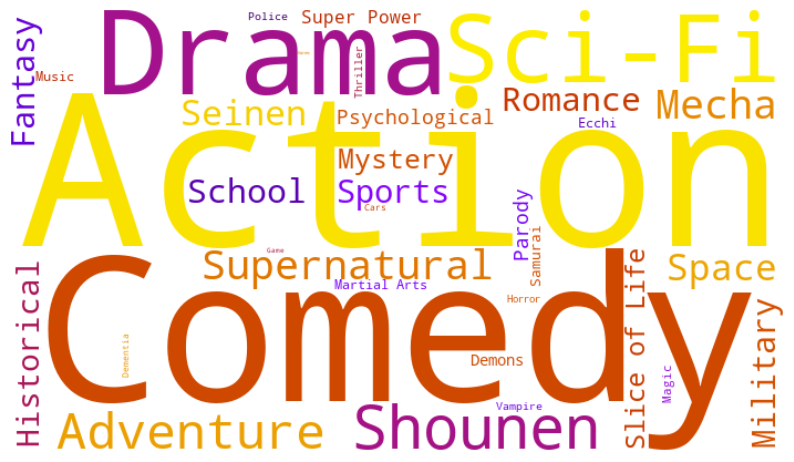

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [259]:
get_user_preferences(11880 , rating_df, df , plot=True)

In [260]:
get_user_preferences(11880 , rating_df, df , plot=False)

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [261]:
def get_user_recommendations(similar_users , user_pref ,df , synopsis_df, rating_df, n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id) , rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i,anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name,str):
                    frame = getAnimeFrame(anime_name,df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = getSynopsis(int(anime_id),synopsis_df)

                    recommended_animes.append({
                        "n" : n_user_pref,
                        "anime_name" : anime_name,
                        "Genres" : genre,
                        "Synopsis": synopsis
                    })
    return pd.DataFrame(recommended_animes).head(n)
            



    

In [288]:
recommended_animes = []
anime_list = []

for user_id in find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded).similar_users.values:
    pref_list = get_user_preferences(int(user_id) , rating_df, df)
    # print(pref_list.shape)

    pref_list = pref_list[~pref_list.eng_version.isin(get_user_preferences(11880 , rating_df, df , plot=False).eng_version.values)]
    # print(pref_list.head(2))


    if not pref_list.empty:
        anime_list.append(pref_list.eng_version.values)

In [293]:
anime_list[0].shape

(214,)

In [294]:
type(anime_list)

list

In [295]:
anime_list = pd.DataFrame(anime_list)



In [296]:
anime_list.shape

(10, 527)

In [298]:
sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(10)

In [299]:
sorted_list

,count
Code Geass:Lelouch of the Rebellion R2,8
Full Metal Panic? Fumoffu,7
Howl's Moving Castle,7
Code Geass:Lelouch of the Rebellion,7
Death Note,7
Angel Beats!,7
Ghost in the Shell:Stand Alone Complex,6
Evangelion:1.0 You Are (Not) Alone,6
5 Centimeters Per Second,6
Gurren Lagann The Movie:Childhood's End,6


In [300]:
(sorted_list.index)

Index(['Code Geass:Lelouch of the Rebellion R2', 'Full Metal Panic? Fumoffu',
       'Howl's Moving Castle', 'Code Geass:Lelouch of the Rebellion',
       'Death Note', 'Angel Beats!', 'Ghost in the Shell:Stand Alone Complex',
       'Evangelion:1.0 You Are (Not) Alone', '5 Centimeters Per Second',
       'Gurren Lagann The Movie:Childhood's End'],
      dtype='object')

In [303]:
sorted_list[sorted_list.index == anime_name]

,count
Gurren Lagann The Movie:Childhood's End,6


In [302]:
for i,anime_name in enumerate(sorted_list.index):

    print(i,anime_name)
    n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]
    print(n_user_pref)
    
    # if isinstance(anime_name,str):
    #     frame = getAnimeFrame(anime_name,df)
    #     anime_id = frame.anime_id.values[0]
    #     genre = frame.Genres.values[0]
    #     synopsis = getSynopsis(int(anime_id),synopsis_df)

    #     recommended_animes.append({
    #         "n" : n_user_pref,
    #         "anime_name" : anime_name,
    #         "Genres" : genre,
    #         "Synopsis": synopsis
    #     })

0 Code Geass:Lelouch of the Rebellion R2
8
1 Full Metal Panic? Fumoffu
7
2 Howl's Moving Castle
7
3 Code Geass:Lelouch of the Rebellion
7
4 Death Note
7
5 Angel Beats!
7
6 Ghost in the Shell:Stand Alone Complex
6
7 Evangelion:1.0 You Are (Not) Alone
6
8 5 Centimeters Per Second
6
9 Gurren Lagann The Movie:Childhood's End
6


In [304]:
def get_user_recommendations(similar_users , user_pref ,df , synopsis_df, rating_df, n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id) , rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i,anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name,str):
                    frame = getAnimeFrame(anime_name,df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = getSynopsis(int(anime_id),synopsis_df)

                    recommended_animes.append({
                        "n" : n_user_pref,
                        "anime_name" : anime_name,
                        "Genres" : genre,
                        "Synopsis": synopsis
                    })
    return pd.DataFrame(recommended_animes).head(n)
            



    

In [305]:
similar_users =find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

In [306]:
user_pref = get_user_preferences(11880 , rating_df, df , plot=False)

In [309]:
get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df)

,n,anime_name,Genres,Synopsis
0,8,Code Geass:Lelouch of the Rebellion R2,"Action, Military, Sci-Fi, Super Power, Drama, Mecha","One year has passed since the Black Rebellion, a failed uprising against the Holy Britannian Empire led by the masked vigilante Zero, who is now missing. At a loss without their revolutionary leader, Area 11's resistance group—the Black Knights—find themselves too powerless to combat the brutality inflicted upon the Elevens by Britannia, which has increased significantly in order to crush any hope of a future revolt. Lelouch Lamperouge, having lost all memory of his double life, is living peacefully alongside his friends as a high school student at Ashford Academy. His former partner C.C., unable to accept this turn of events, takes it upon herself to remind him of his past purpose, hoping that the mastermind Zero will rise once again to finish what he started, in this thrilling conclusion to the series."
1,7,Full Metal Panic? Fumoffu,"Action, Comedy, School","It's back-to-school mayhem with Kaname Chidori and her war-freak classmate Sousuke Sagara as they encounter more misadventures in and out of Jindai High School. But when Kaname gets into some serious trouble, Sousuke takes the guise of Bonta-kun—the gun-wielding, butt-kicking mascot. And while he struggles to continue living as a normal teenager, Sousuke also has to deal with protecting his superior officer Teletha Testarossa, who has decided to take a vacation from Mithril and spend a couple of weeks as his and Kaname's classmate. (Source: ANN)"
2,7,Howl's Moving Castle,"Adventure, Drama, Fantasy, Romance","That jumbled piece of architecture, that cacophony of hissing steam and creaking joints, with smoke billowing from it as it moves on its own... That castle is home to the magnificent wizard Howl, infamous for both his magical prowess and for being a womanizer—or so the rumor goes in Sophie Hatter's small town. Sophie, as the plain daughter of a hatmaker, does not expect much from her future and is content with working hard in the shop. However, Sophie's simple life takes a turn for the exciting when she is ensnared in a disturbing situation, and the mysterious wizard appears to rescue her. Unfortunately, this encounter, brief as it may be, spurs the vain and vengeful Witch of the Waste—in a fit of jealousy caused by a past discord with Howl—to put a curse on the maiden, turning her into an old woman. In an endeavor to return to normal, Sophie must accompany Howl and a myriad of eccentric companions—ranging from a powerful fire demon to a hopping scarecrow—in his living castle, on a dangerous adventure as a raging war tears their kingdom apart."
3,7,Code Geass:Lelouch of the Rebellion,"Action, Military, Sci-Fi, Super Power, Drama, Mecha, School","In the year 2010, the Holy Empire of Britannia is establishing itself as a dominant military nation, starting with the conquest of Japan. Renamed to Area 11 after its swift defeat, Japan has seen significant resistance against these tyrants in an attempt to regain independence. Lelouch Lamperouge, a Britannian student, unfortunately finds himself caught in a crossfire between the Britannian and the Area 11 rebel armed forces. He is able to escape, however, thanks to the timely appearance of a mysterious girl named C.C., who bestows upon him Geass, the ""Power of Kings."" Realizing the vast potential of his newfound ""power of absolute obedience,"" Lelouch embarks upon a perilous journey as the masked vigilante known as Zero, leading a merciless onslaught against Britannia in order to get revenge once and for all."
4,7,Death Note,"Mystery, Police, Psychological, Supernatural, Thriller, Shounen","shinigami, as a god of death, can kill any person—provided they see their victim's face and write their victim's name in a notebook called a Death Note. One day, Ryuk, bored by the shinigami lifestyle and interested in seeing how a human would use a Death Note, drops one into the human realm. High school stude

### HYBRID RECOMMENDER SYSTEM

In [310]:
def hybrid_recommendation(user_id , user_weight=0.5, content_weight =0.5):

    ## User Recommndation

    similar_users =find_similar_users(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref = get_user_preferences(user_id , rating_df, df)
    user_recommended_animes =get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df)
    

    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)

    #### Content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")
    
    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight  

    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] , reverse=True)

    return [anime for anime , score in sorted_animes[:10]] 



In [311]:
hybrid_recommendation(11880)

['Code Geass:Lelouch of the Rebellion R2', 'Full Metal Panic? Fumoffu', "Howl's Moving Castle", 'Code Geass:Lelouch of the Rebellion', 'Death Note', 'Angel Beats!', 'Ghost in the Shell:Stand Alone Complex', 'Evangelion:1.0 You Are (Not) Alone', '5 Centimeters Per Second', "Gurren Lagann The Movie:Childhood's End"]


['Code Geass:Lelouch of the Rebellion R2',
 'Code Geass:Lelouch of the Rebellion',
 'Fullmetal Alchemist:Brotherhood',
 'Death Note',
 'Angel Beats!',
 'Attack on Titan',
 'One Punch Man',
 'Your Name.',
 'Spirited Away',
 'Fate/Zero Season 2']